In [1]:
# This notebook contains the code to differentiate images based on sports

In [2]:
# importing the libraries
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch libraries and modules
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch

In [3]:
import wget
import time
import os
import copy

## Loading the data

In [4]:
PATH = "/home/ubuntu/datasets/sports_images/"
sz=224

In [5]:
files = os.listdir(f'{PATH}train/baseball')[:5]
files

['bs36.jpg', 'bs37.jpg', 'bs5.jpg', 'bs21.jpg', 'bs39.jpeg']

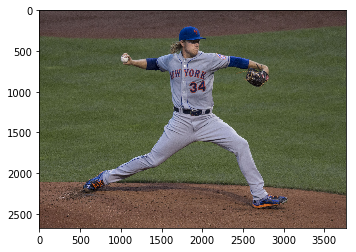

In [6]:
img = plt.imread(f'{PATH}train/baseball/{files[0]}')
plt.imshow(img);

In [7]:
img.shape

(2672, 3763, 3)

The numbers above mean the image has 2672*3763 pixels with 3 channels (R, G, and B).
Lets verify it using img.size function

In [8]:
img.size

30164208

In [9]:
2672*3763*3

30164208

Let's have a look at what type of numbers are stored by selecting first 4 rows and columns.

In [10]:
img[:4,:4]

array([[[88, 74, 74],
        [86, 72, 72],
        [78, 64, 64],
        [73, 59, 59]],

       [[88, 74, 74],
        [87, 73, 73],
        [83, 69, 69],
        [79, 65, 65]],

       [[84, 70, 70],
        [86, 72, 72],
        [85, 71, 71],
        [83, 69, 69]],

       [[81, 67, 67],
        [83, 69, 69],
        [85, 71, 71],
        [83, 69, 69]]], dtype=uint8)

## Building a simple model

We're going to use a pre-trained model, that is, a model created by someone else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision.

### Download pre-trained models

I used the following links to download the model

    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'

In [11]:
# url = "https://download.pytorch.org/models/resnet152-b121ed2d.pth"
# wget.download(url, '/home/ubuntu/pretrained_models/')

Lets check the size of each model

In [12]:
# !ls -l --block-size=M /home/ubuntu/pretrained_models/

As you can see above, when the number of number of layers double the pre-trained models also double in size.

If you wish to check all available pretrained models:

In [13]:
from torchvision import models
dir(models)

['AlexNet',
 'DenseNet',
 'Inception3',
 'ResNet',
 'SqueezeNet',
 'VGG',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'inception',
 'inception_v3',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

### Data Preprocessing

List of all transforms here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [15]:
data_dir = '/home/ubuntu/datasets/sports_images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [16]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [17]:
len(dataloaders), type(dataloaders)

(2, dict)

In [18]:
dataloaders.items()

dict_items([('train', <torch.utils.data.dataloader.DataLoader object at 0x7fa314444e80>), ('val', <torch.utils.data.dataloader.DataLoader object at 0x7fa3144445f8>)])

In [19]:
len(dataloaders['train']), len(dataloaders['val'])

(43, 20)

In [20]:
dataloaders['train'].dataset.imgs

[('/home/ubuntu/datasets/sports_images/train/baseball/bs1.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs10.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs11.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs12.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs13.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs14.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs15.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs16.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs17.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs18.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs19.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs2.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs20.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/train/baseball/bs21.jpg', 0),
 ('/home/ubuntu/datasets/sports_imag

In [21]:
dataloaders['val'].dataset.transform

Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [22]:
class_names = image_datasets['train'].classes

In [23]:
class_names

['baseball', 'basketball', 'cricket', 'soccer']

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
device

device(type='cuda', index=0)

In [26]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [27]:
dataset_sizes

{'train': 169, 'val': 78}

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [29]:
# Get a batch of training data as per the size of batch
inputs, classes = next(iter(dataloaders['train']))

In [30]:
classes

tensor([0, 1, 2, 3])

In [31]:
import torchvision

In [32]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

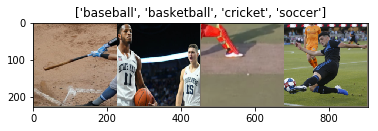

In [33]:
imshow(out, title=[class_names[x] for x in classes])

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Generic function to display predictions for a few images

In [35]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


#### Finetuning the convnet

In [36]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 4.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


#### Train and evaluate

In [37]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1537 Acc: 0.4793
val Loss: 0.4071 Acc: 0.8077

Epoch 1/24
----------
train Loss: 0.6642 Acc: 0.7456
val Loss: 0.2517 Acc: 0.8846

Epoch 2/24
----------
train Loss: 0.5914 Acc: 0.7751
val Loss: 0.2824 Acc: 0.8846

Epoch 3/24
----------
train Loss: 0.5108 Acc: 0.8107
val Loss: 0.2198 Acc: 0.8974

Epoch 4/24
----------
train Loss: 0.6651 Acc: 0.6982
val Loss: 0.3158 Acc: 0.8590

Epoch 5/24
----------
train Loss: 0.4454 Acc: 0.8462
val Loss: 0.2551 Acc: 0.8974

Epoch 6/24
----------
train Loss: 0.6385 Acc: 0.7929
val Loss: 0.4088 Acc: 0.8590

Epoch 7/24
----------
train Loss: 0.5430 Acc: 0.8047
val Loss: 0.5526 Acc: 0.8590

Epoch 8/24
----------
train Loss: 0.5304 Acc: 0.7929
val Loss: 0.3561 Acc: 0.8974

Epoch 9/24
----------
train Loss: 0.3225 Acc: 0.8876
val Loss: 0.2059 Acc: 0.9231

Epoch 10/24
----------
train Loss: 0.3201 Acc: 0.8757
val Loss: 0.2040 Acc: 0.9231

Epoch 11/24
----------
train Loss: 0.3221 Acc: 0.8757
val Loss: 0.1721 Acc: 0.9487

Ep

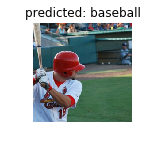

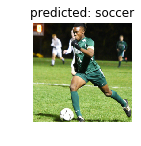

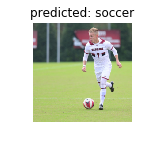

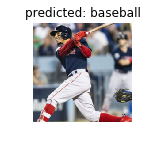

In [38]:
visualize_model(model_ft)

Let's try a more complex models than ResNet18.

In [42]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [43]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2951 Acc: 0.3787
val Loss: 0.5508 Acc: 0.7692

Epoch 1/24
----------
train Loss: 0.7100 Acc: 0.7396
val Loss: 0.1965 Acc: 0.9231

Epoch 2/24
----------
train Loss: 0.7072 Acc: 0.7337
val Loss: 0.1793 Acc: 0.9231

Epoch 3/24
----------
train Loss: 0.6227 Acc: 0.7574
val Loss: 0.1267 Acc: 0.9615

Epoch 4/24
----------
train Loss: 0.5421 Acc: 0.7988
val Loss: 0.2095 Acc: 0.9359

Epoch 5/24
----------
train Loss: 0.5895 Acc: 0.8047
val Loss: 0.3231 Acc: 0.8974

Epoch 6/24
----------
train Loss: 0.5924 Acc: 0.7692
val Loss: 0.1935 Acc: 0.8846

Epoch 7/24
----------
train Loss: 0.8114 Acc: 0.7278
val Loss: 0.1798 Acc: 0.9231

Epoch 8/24
----------
train Loss: 0.4886 Acc: 0.8166
val Loss: 0.1539 Acc: 0.9231

Epoch 9/24
----------
train Loss: 0.3576 Acc: 0.8698
val Loss: 0.1969 Acc: 0.9103

Epoch 10/24
----------
train Loss: 0.2636 Acc: 0.9053
val Loss: 0.1322 Acc: 0.9487

Epoch 11/24
----------
train Loss: 0.3345 Acc: 0.8580
val Loss: 0.1692 Acc: 0.9359

Ep

In [44]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/ubuntu/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:14, 12528409.84it/s]


In [45]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2666 Acc: 0.4379
val Loss: 0.3254 Acc: 0.9359

Epoch 1/24
----------
train Loss: 0.5862 Acc: 0.7692
val Loss: 0.1763 Acc: 0.9487

Epoch 2/24
----------
train Loss: 0.4318 Acc: 0.8284
val Loss: 0.1340 Acc: 0.9359

Epoch 3/24
----------
train Loss: 0.5180 Acc: 0.8166
val Loss: 0.1521 Acc: 0.9359

Epoch 4/24
----------
train Loss: 0.4344 Acc: 0.8698
val Loss: 0.3209 Acc: 0.8718

Epoch 5/24
----------
train Loss: 0.5989 Acc: 0.7811
val Loss: 0.3825 Acc: 0.8205

Epoch 6/24
----------
train Loss: 0.3688 Acc: 0.8402
val Loss: 0.1853 Acc: 0.9615

Epoch 7/24
----------
train Loss: 0.5664 Acc: 0.7988
val Loss: 0.3770 Acc: 0.8846

Epoch 8/24
----------
train Loss: 0.3177 Acc: 0.8817
val Loss: 0.1940 Acc: 0.9231

Epoch 9/24
----------
train Loss: 0.3294 Acc: 0.8935
val Loss: 0.2022 Acc: 0.9103

Epoch 10/24
----------
train Loss: 0.2864 Acc: 0.9053
val Loss: 0.1388 Acc: 0.9487

Epoch 11/24
----------
train Loss: 0.3666 Acc: 0.8639
val Loss: 0.2832 Acc: 0.8974

Ep

It seems using more complex model did give us a little better accuracy.